logo_dantion.png

TBD . We created this project to complete our study in **Bangkit 2022 led by Google, GoTo and Traveloka**

## **1. Import Dependencies**
There are several libraries that needed to be installed. If you're not install it yet, delete the hashtag

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio

from IPython import display

from tensorflow.keras import layers
from tensorflow.keras import models

## **2. Import dataset**
You can download our dataset via this link :

In [94]:
#from google.colab import files
#data_dir = '/content/gdrive/MyDrive/Audio Dataset Dantion/FINAL DATASET'

In [2]:
os.getcwd()

'd:\\1MPORTANT!\\BANGKIT\\CAPSTONE\\machine-learning'

Define data directory and then import the dataset

In [3]:
data_dir = 'New Data/FINAL'
parent_dir = 'd:/1MPORTANT!/BANGKIT/CAPSTONE' 
#We save our data in different parent directory, so we need to change de dir
os.chdir(parent_dir) 

Let's see what the dataset about

In [4]:
event = os.listdir(data_dir)

In [5]:
print(f"Classes : {event}")

Classes : ['BEGAL', 'KEBAKARAN', 'KECELAKAAN', 'MALING', 'PENCURI', 'RAMPOK', 'RANDOM', 'TABRAKAN']


In [6]:
def get_numfiles(dir):
    """Get number of files in a directory"""
    count = 0
    for _, _, files in os.walk(dir):
        count += len(files)
    return count

In [7]:
print(f"Total dataset : {str(get_numfiles(data_dir))}")
print(f"Class: {event}")

Total dataset : 2310
Class: ['BEGAL', 'KEBAKARAN', 'KECELAKAAN', 'MALING', 'PENCURI', 'RAMPOK', 'RANDOM', 'TABRAKAN']


Import the dataset, preprocess, and batch them

In [8]:
def get_files(dir):
    '''Get all file path and convert to EagerTensor'''
    #Get .wav files directory
    filedir = os.path.join(dir,"*.wav") 

    #Returns a list of files that match the given pattern
    files = tf.io.gfile.glob(filedir) 

    #Randomly shuffles a tensor along its first dimension
    files = tf.random.shuffle(files)
    
    return files

In [9]:
def split_data(event,data,ratio1,ratio2,ratio3):
    '''Split dataset into desired ratio'''
    #Validating ratio, in total must be 100%
    files = get_files(data)
    if ratio1+ratio2+ratio3 == 100 :
        ratio1 = round(len(files)*ratio1/100)
        ratio2 = round(len(files)*ratio2/100)
        ratio3 = round(len(files)*ratio3/100)
        globals()[f"{event}_train"] = files[:ratio1]
        globals()[f"{event}_val"] = files[ratio1: ratio1 + ratio2]
        globals()[f"{event}_test"] = files[-ratio3:]
        splitted = [globals()[f"{event}_train"],globals()[f"{event}_val"] ,globals()[f"{event}_test"]]
    else :
        raise ValueError('Exceeding the limit ratio, the total ratio must be 100% but you got ' + str(ratio1+ratio2+ratio3) + '%')
    return splitted

In [10]:
train_raw = []
val_raw = []
test_raw = []

for e in event :
    file_dir = os.path.join(data_dir,e)
    split_train,split_val,split_test = split_data(e,file_dir,80,10,10)
    train_raw.append(split_train)
    val_raw.append(split_val)
    test_raw.append(split_test)

In [11]:
def append_and_shuffle(data1,data2):
    '''Append eager tensor'''
    appended = np.append(data1,data2)
    np.random.shuffle(appended)
    return appended

In [13]:
train = np.array([])
i = 0
while i < len(train_raw):
    train = np.append(train,train_raw[i])
    i += 1

In [14]:
val = np.array([])
i = 0
while i < len(val_raw):
    val = np.append(val,val_raw[i])
    i += 1

test = np.array([])
i = 0
while i < len(test_raw):
    test = np.append(test,test_raw[i])
    i += 1

In [15]:
np.random.shuffle(train)
np.random.shuffle(val)
np.random.shuffle(test)

In [16]:
print("Number of files: ")
print(f"Train files: {len(train)} \nValidation Files: {len(val)}\nTest files: {len(test)}")

Number of files: 
Train files: 1848 
Validation Files: 231
Test files: 231


## cek chunk

In [109]:
import wave
import librosa
import soundfile as sf
import glob
  
def check_chunks(DIR, CORRUPT_DIR):
      files_list = glob.glob(DIR + '/**/*.wav', recursive=True)
      i = 0
  
      for filename in files_list:
  
          try:
              # get size of data chunk and add size of FMT header = 44
              with wave.open(filename, 'r') as fin:
                  header_fsize = (fin.getnframes() * fin.getnchannels() * fin.getsampwidth()) + 44
  
              # get actual filesize
              file_fsize = os.path.getsize(filename)
  
              # compare both sizes
              if header_fsize != file_fsize:
                  print("Found a file with extra chunks: ", filename)
                  print(header_fsize, file_fsize)
                  i = i + 1
  
                  new_full_filename = os.path.splitext(filename)  ## just separate out wav from name
                  new_filename = new_full_filename[0] + "_processed" + ".wav"
                  audio_in, sr = librosa.load(filename, sr=16000)
                  sf.write(new_filename, audio_in, 16000, subtype='PCM_16')
                  print('File fixed and saved as: ', new_filename)
  
                  # try to fix file and save with suffix "processed" and move original file to another folder
                  try:
                      FIXED_CHUNK_DIR = os.path.join(CORRUPT_DIR, "fixed_chunks")
                      if not os.path.isdir(FIXED_CHUNK_DIR):
                          os.mkdir(FIXED_CHUNK_DIR)
                      shutil.move(filename, FIXED_CHUNK_DIR)
                      print('Moving original file to: ', FIXED_CHUNK_DIR)
  
                  # sometimes, the original file fails to move, but the processed file is successfully created
                  except:
                      print("Original file cannot be moved, please move manually")
                      continue
  
          # in case the file isn't fixed:
          except:
              # trying to at least move it out of the correct sound file folder 
              try:
                  CORRUPT_CHUNK_DIR = os.path.join(CORRUPT_DIR, "corrupt_chunks")
                  if not os.path.isdir(CORRUPT_CHUNK_DIR):
                      os.mkdir(CORRUPT_CHUNK_DIR)
  
                  print("This file cannot be fixed:  ", filename, "\nMoving it to ", CORRUPT_CHUNK_DIR)
                  shutil.move(filename, CORRUPT_CHUNK_DIR)
                  os.remove(filename)
  
              # if the unfixed file refuses to move
              except:
                  print("This file cannot be fixed: ", filename, "\nPlease remove manually")
                  continue
  
              continue
      print("done")
      return

In [18]:
check_chunks('New Data/FINAL/','New Data')

done


## **Read Audio and Labeling**

In [17]:
def decode_audio(audio_dir):
  '''Decode .wav Audio into Waveform Audio Tensor'''
  #Read the audio file
  audiofile = tf.io.read_file(audio_dir)
  #Decode the file into wav mono channel
  audio, sr = tf.audio.decode_wav(audiofile,desired_channels=1) 
  #Squeeze to get rid the trailing axis
  audio = tf.squeeze(audio, axis=-1)
  sr = tf.cast(sr, dtype=tf.int64)
  print(sr)
  #Resample sample rate
  audio = tfio.audio.resample(audio, rate_in = sr, rate_out = 16000)
  return audio

### ini ke bawah 👇👇👇

In [18]:
def get_waveform_and_label(file_path):
  waveform = decode_audio(file_path)
  label = tf.strings.split(input=file_path,sep=os.path.sep)[-2]
  return waveform, label

In [19]:
files_ds = tf.data.Dataset.from_tensor_slices(train)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=tf.data.AUTOTUNE)

Tensor("Cast:0", shape=(), dtype=int64)


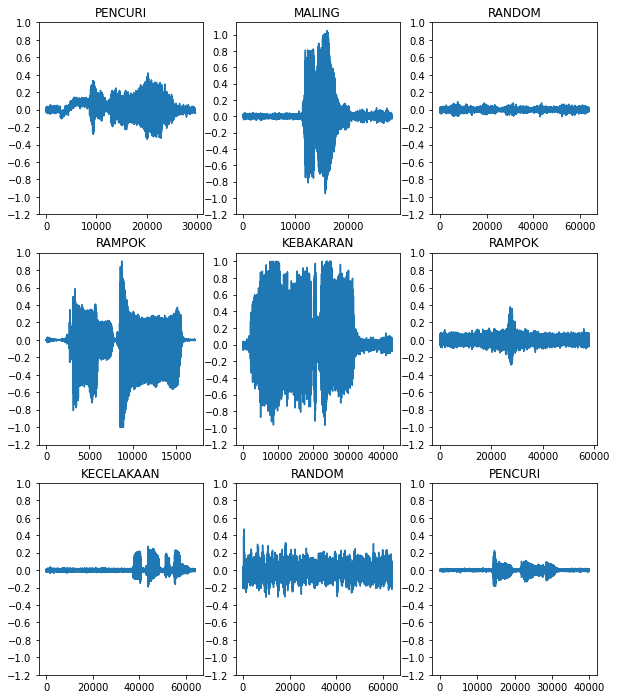

In [20]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [21]:
def get_spectrogram(waveform):
    spectrogram = tfio.audio.spectrogram(waveform, nfft=512, window=512, stride=256)
    return spectrogram

In [22]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [23]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
#display.display(display.Audio(waveform, rate=16000))

Label: PENCURI
Waveform shape: (29696,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [24]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

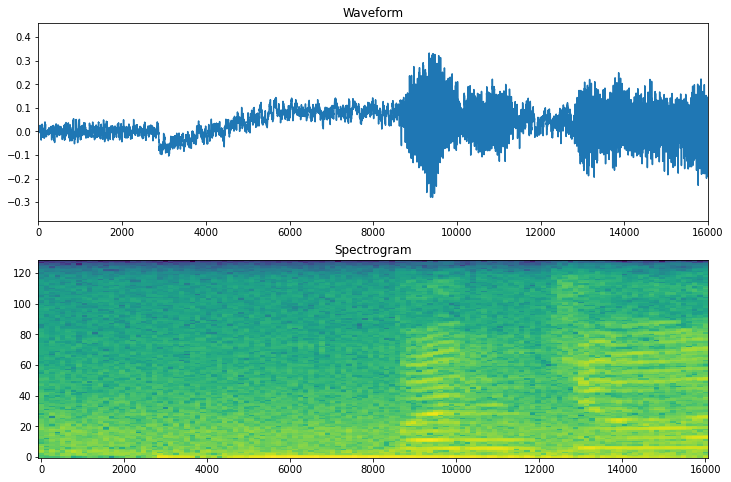

In [25]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [26]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == event)
  return spectrogram, label_id

In [27]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)

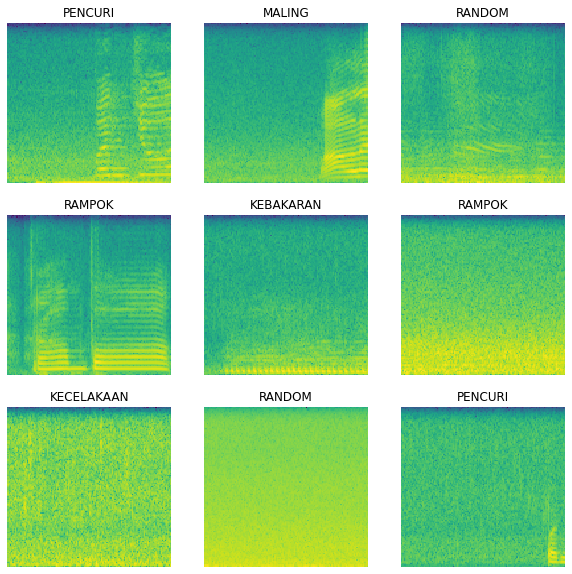

In [28]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(event[label_id.numpy()])
  ax.axis('off')

plt.show()

## Build Model

In [29]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=tf.data.AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=tf.data.AUTOTUNE)
  return output_ds

In [30]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val)
test_ds = preprocess_dataset(test)

Tensor("Cast:0", shape=(), dtype=int64)
Tensor("Cast:0", shape=(), dtype=int64)


## sampe sini masih sama

In [31]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [32]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [38]:
#hyperparameter
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(event)

model = models.Sequential([
    Input(shape=input_shape),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPooling2D(padding='same'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(num_labels, activation = 'softmax')])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 124, 129, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 65, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 65, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 31, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy,
    metrics=['accuracy'],
)

In [35]:
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS,
)

Epoch 1/30
58/58 [==============================] - 64s 1s/step - loss: 1.6292 - accuracy: 0.3918 - val_loss: 1.5675 - val_accuracy: 0.3853
Epoch 2/30
58/58 [==============================] - 47s 802ms/step - loss: 1.5173 - accuracy: 0.4080 - val_loss: 1.4850 - val_accuracy: 0.3939
Epoch 3/30
58/58 [==============================] - 41s 702ms/step - loss: 1.4700 - accuracy: 0.4324 - val_loss: 1.4396 - val_accuracy: 0.3983
Epoch 4/30
58/58 [==============================] - 41s 710ms/step - loss: 1.4143 - accuracy: 0.4399 - val_loss: 1.4088 - val_accuracy: 0.4286
Epoch 5/30
58/58 [==============================] - 41s 700ms/step - loss: 1.3819 - accuracy: 0.4524 - val_loss: 1.4312 - val_accuracy: 0.4329
Epoch 6/30
58/58 [==============================] - 41s 699ms/step - loss: 1.3705 - accuracy: 0.4556 - val_loss: 1.3681 - val_accuracy: 0.4286
Epoch 7/30
58/58 [==============================] - 40s 689ms/step - loss: 1.3431 - accuracy: 0.4708 - val_loss: 1.3451 - val_accuracy: 0.4502
Ep

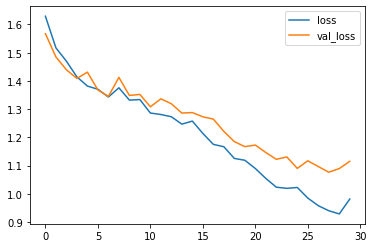

In [36]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

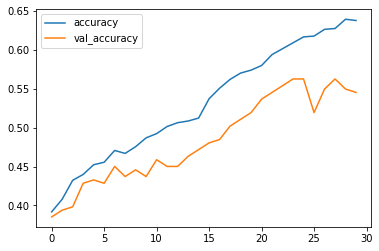

In [37]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## ini ke bawah juga masih sama

In [185]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [186]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


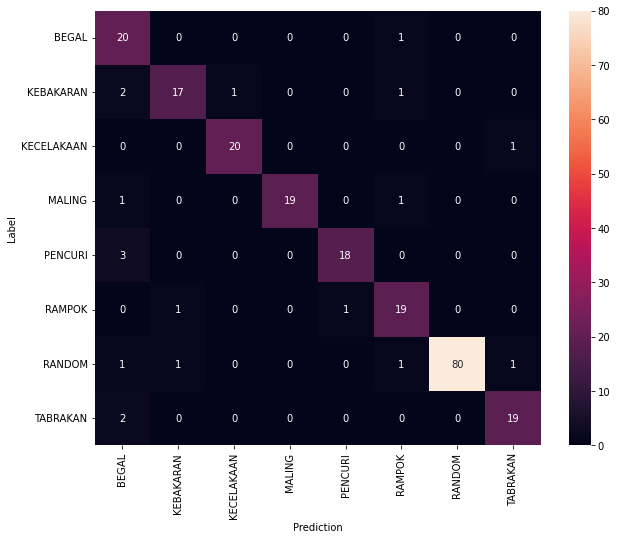

In [187]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=event,
            yticklabels=event,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

sampe sini

## Save Model

In [188]:
savedir='machine-learning/model30epochs'

In [189]:
model.save(savedir)

INFO:tensorflow:Assets written to: machine-learning/model30epochs\assets


INFO:tensorflow:Assets written to: machine-learning/model30epochs\assets


In [131]:
#modeldir = '.h5
loadedmodel = tf.keras.models.load_model(savedir)
loadedmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 129, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 65, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 65, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 31, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 15, 64)       0

In [132]:
os.getcwd()

'd:\\1MPORTANT!\\BANGKIT\\CAPSTONE'

In [144]:
input_shape = [1,124,129]
def predictingload(path):
  waveform = decode_audio(path)
  spec = get_spectrogram(waveform) 
  spec = tf.reshape(spec, input_shape)
  predict = list(loadedmodel.predict([spec])[0])
  print(f'Predict Probability : {predict}')
  predicted = max(predict)
  print(predicted)
  index = predict.index(predicted)
  predictresult = event[index]
  plt.figure(figsize=(12,5))
  plt.title(f"The audio {path} is predicted as {predictresult}")
  predictgraph(spec)
  display.display(display.Audio(waveform, rate=16000))

tf.Tensor(44100, shape=(), dtype=int64)
Predict Probability : [8.8506415e-05, 0.9999114, 2.9658518e-09, 5.3487235e-19, 4.3625108e-16, 5.6163197e-15, 1.862087e-18, 2.0673824e-11]
0.9999114


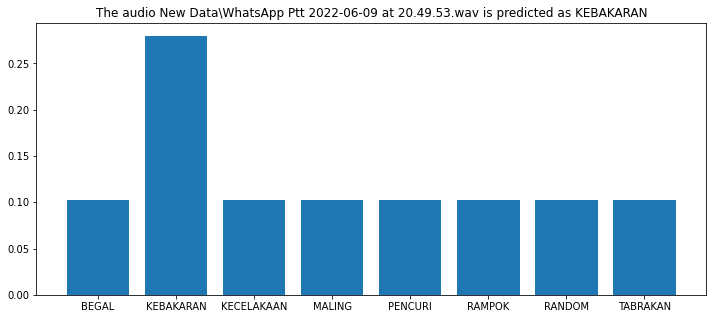

In [145]:
predictingload('New Data\WhatsApp Ptt 2022-06-09 at 20.49.53.wav')

## Try with your audio !

In [136]:
def predictgraph(spec):
    prediction = loadedmodel(spec)
    plt.bar(event, tf.nn.softmax(prediction[0]))
    plt.show()

In [137]:
def predicting(path):
  waveform = decode_audio(path)
  spec = get_spectrogram(waveform) 
  spec = tf.reshape(spec, input_shape)
  predict = list(model.predict([spec])[0])
  print(f'Predict Probability : {predict}')
  predicted = max(predict)
  print(predicted)
  index = predict.index(predicted)
  predictresult = event[index]
  plt.title(f'Predictions for "{predictresult}"')
  predictgraph(spec)
  display.display(display.Audio(waveform, rate=16000))
  return f"The audio {path} is {predictresult}"

In [25]:
predicting(data_dir+'/begal/begal_1.wav')

tf.Tensor(48000, shape=(), dtype=int64)


NameError: name 'model' is not defined

In [56]:
data_dir

'New Data/FINAL'

## Load Model

## **Creating TFLITE Model**

In [196]:
export_dir = 'machine-learning/model30epochslite/'
tf.saved_model.save(model,export_dir=export_dir)

INFO:tensorflow:Assets written to: machine-learning/model30epochslite/assets


INFO:tensorflow:Assets written to: machine-learning/model30epochslite/assets


In [197]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [198]:
import pathlib

In [203]:
tflite_model_file = pathlib.Path('machine-learning/model30epochs.tflite')
tflite_model_file.write_bytes(tflite_model)

1757040

### Add metadata to tflite

In [199]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [200]:
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "DANTION Audio Classification"
model_meta.description = ("Identify 7 event for emergency button "
                          "feature in DANTION app.")
model_meta.version = "v1"
model_meta.author = "C22-PS121 Bangkit Product Capstone Project Team"

In [201]:
input_meta = _metadata_fb.TensorMetadataT()
output_meta = _metadata_fb.TensorMetadataT()

In [219]:
input_meta.name = "wav audio"
input_meta.description = ("Input audio clip to be classified "
                          "(16 kHz float32 waveform samples in range -1.0..1.0).")
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.AudioPropertiesT()
input_meta.content.contentProperties.sampleRate = 16000
input_meta.content.contentProperties.channels = 1


In [248]:
output_meta.name = "classifier"
output_meta.description = ("Output probability for each event: "
                           "['BEGAL', 'KEBAKARAN', 'KECELAKAAN', 'MALING', 'PENCURI', 'RAMPOK', 'RANDOM', 'TABRAKAN']")

#Stats
output_stats = _metadata_fb.StatsT()
output_stats.max= 1
output_stats.min= 0

#Crete Label File
event = ['BEGAL', 'KEBAKARAN', 'KECELAKAAN', 'MALING', 'PENCURI', 'RAMPOK', 'RANDOM', 'TABRAKAN']
pathtxt = 'machine-learning/event.txt'
with open(pathtxt,'w') as labelfile:
    for item in event:
        labelfile.write("%s\n" %item)

#Add label file
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(pathtxt)
label_file.description = "Label for audio classification that model can classify"
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [249]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [252]:
populator = _metadata.MetadataPopulator.with_model_file('machine-learning/model30epochs.tflite')
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([pathtxt])
populator.populate()

In [ ]:
import tensorflow as tf
import numpy as np
import zipfile

interpreter = tf.lite.Interpreter('machine-learning/model30epochs.tflite')

input_details = interpreter.get_input_details()
waveform_input_index = input_details[0]['index']
output_details = interpreter.get_output_details()
scores_output_index = output_details[0]['index']

# Input: 0.975 seconds of silence as mono 16 kHz waveform samples.
waveform = np.zeros(int(round(0.975 * 16000)), dtype=np.float32)
print(waveform.shape)

interpreter.resize_tensor_input(waveform_input_index, [waveform.size], strict=True)
interpreter.allocate_tensors()
interpreter.set_tensor(waveform_input_index, waveform)
interpreter.invoke()
scores = interpreter.get_tensor(scores_output_index)
print(scores.shape) 

top_class_index = scores.argmax()
labels_file = zipfile.ZipFile('machine-learning/model30epochs.tflite').open('event.txt')
labels = [l.decode('utf-8').strip() for l in labels_file.readlines()]
print(len(labels)) 
print(labels[top_class_index]) 